In [354]:
import numpy as np
import hickle as hkl
%run ../../src/preprocessing/whittaker_smoother.py
%run ../../src/preprocessing/cloud_removal.py
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange, tqdm_notebook

ModuleNotFoundError: No module named 'src'

In [530]:
def initialize_smoother(lmbd: int = 800, dim = 72) -> np.ndarray:
    diagonals = np.zeros(2*2+1)
    diagonals[2] = 1.
    for i in range(2):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(2+1)
    shape = (dim - 2, dim)
    E = sparse.eye(dim, format = 'csc')
    D = scipy.sparse.diags(diagonals, offsets, shape)
    D = D.conj().T.dot(D) * lmbd
    coefmat = E + D
    splu_coef = splu(coefmat)
    return splu_coef

def smooth(y: np.ndarray, splu_coef: np.ndarray = splu_coef) -> np.ndarray:
    ''' 
    Apply whittaker smoothing to a 1-dimensional array, returning a 1-dimensional array
    '''
    return splu_coef.solve(np.array(y))

In [531]:
d = x - np.median(x, axis = (0))
mdev = np.median(x, axis = 0)
s = d / mdev

In [604]:
post = hkl.load("../../tile_data/guatemala-gain-2/raw/s2/processed_0_0.hkl")
x = hkl.load("../../tile_data/guatemala-gain-2/raw/s2/0_0.hkl")

In [607]:
interp = hkl.load("../../tile_data/guatemala-gain-2/raw/s2/interp_0_0.hkl")

In [646]:
clouds = hkl.load("../../tile_data/guatemala-gain-2/raw/clouds/clouds_0_0.hkl")
shadows = hkl.load("../../tile_data/guatemala-gain-2/raw/clouds/shadows_0_0.hkl")
clouds = np.copy(clouds) - np.min(clouds, axis = 0)
clouds[np.where(clouds >= 0.3)] = 1.
clouds[np.where(clouds < 0.3)] = 0.
clouds += shadows

In [647]:
np.mean(clouds, axis = (1, 2))

array([0.02187311, 0.58103452, 0.20882017, 0.34329141, 0.11463735,
       0.00061344, 0.        , 0.12507788, 0.10154895, 0.0483183 ,
       0.        , 0.005521  , 0.00544432, 0.20195248, 0.27610252,
       0.05461569, 0.06598357, 0.07137038, 0.        , 0.02279328,
       0.07138955, 0.00701627, 0.13042155, 0.06186199, 0.13162687,
       0.50848278, 0.05572995, 0.56741175, 0.51302131])

In [650]:
np.mean(interp, axis = (1, 2, 3))

array([0.06727037, 0.52648592, 0.78526105, 0.31273184, 0.00758178,
       0.        , 0.42005339, 0.25724631, 0.16901581, 0.        ,
       0.04436446, 0.01723634, 0.42888602, 0.1824924 , 0.20231192,
       0.1891684 , 0.        , 0.12205858, 0.22163061, 0.03898485,
       0.40600648, 0.24608929, 0.36984443, 0.13909603])

In [651]:
to_remove = np.argwhere(np.mean(interp, axis = (1, 2, 3)) > 0.5)
to_remove

array([[1],
       [2]])

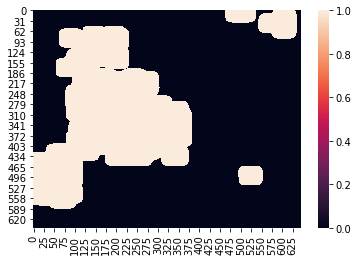

In [648]:
sns.heatmap(interp[3, :, :, 0])

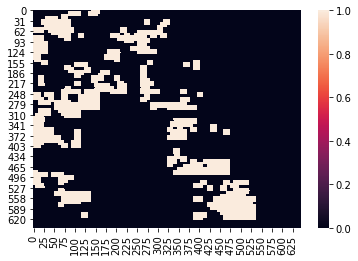

In [640]:
sns.heatmap(shadows[2, :, :])

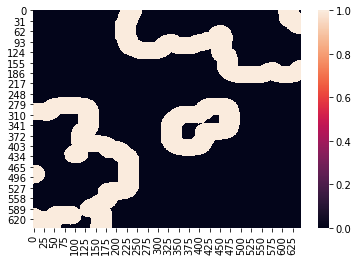

In [563]:
import math
from scipy.ndimage import distance_transform_edt as distance
def calc_dist_map(seg):
    '''Utility function for calc_dist_map_batch that calculates the loss
       importance per pixel based on the surface distance function
    
         Parameters:
          seg (arr):
          
         Returns:
          res (arr):
    '''
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        
    res[np.where(res == 0)] = 1
    res[np.where(res > 25)] = 0
    res[np.where(res < -25)] = 0
    res[np.where(res != 0)] = 1
    return res

dmap = calc_dist_map(interp[4, :, :, 0])

sns.heatmap(dmap)

In [564]:
from scipy.interpolate import RegularGridInterpolator
z = np.copy(post[5, :, :, 0])
post2 = np.copy(post[5, :, :, 0])
z[np.where(dmap == 0)] = np.nan
x = np.arange(0, 646, 1)
y = np.arange(0, 646, 1)
zinterp = RegularGridInterpolator((x, y), z.T)

# new grid to interpolate on
X2, Y2 = np.meshgrid(x, y)
newpoints = np.array((X2, Y2)).T

# actual interpolation
z2 = zinterp(newpoints)
z2_masked = np.ma.array(z2, mask=np.isnan(z2))

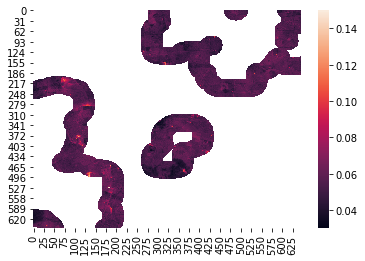

In [565]:
sns.heatmap(z2_masked, vmax = 0.15)

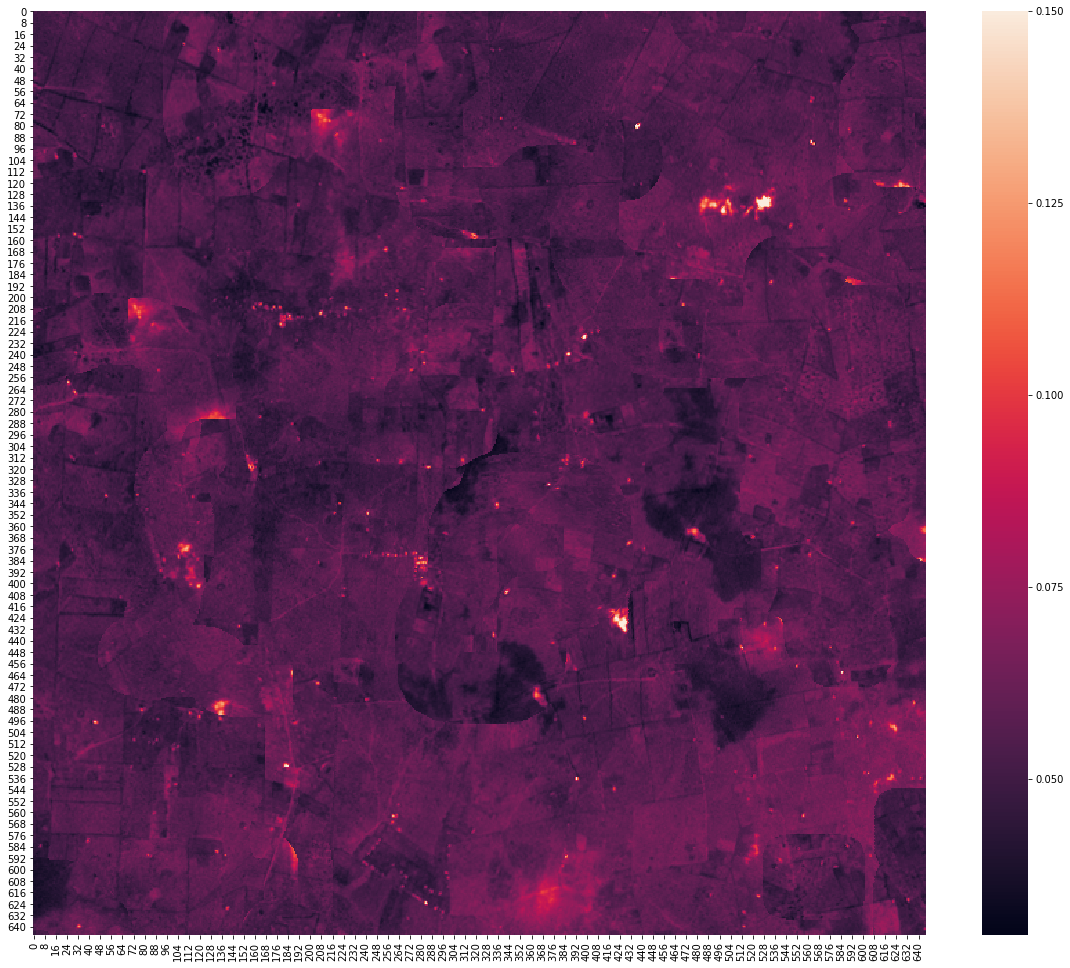

In [566]:
plt.figure(figsize=(20, 17))
z2[np.where(np.isnan(z2))] = post2[np.where(np.isnan(z2))]
sns.heatmap(z2, vmax = 0.15)

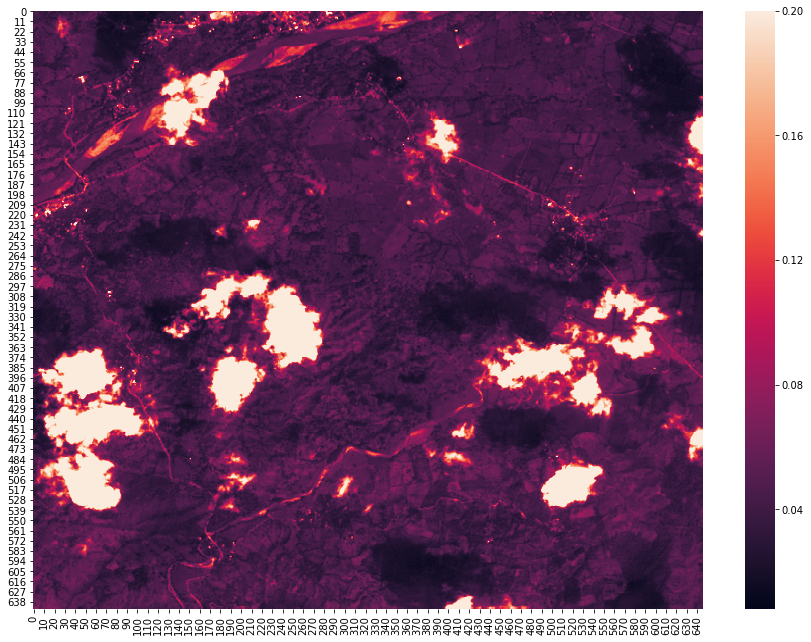

In [642]:
plt.figure(figsize=(15, 11))
sns.heatmap(x[3, :, :, 0], vmax = 0.2)

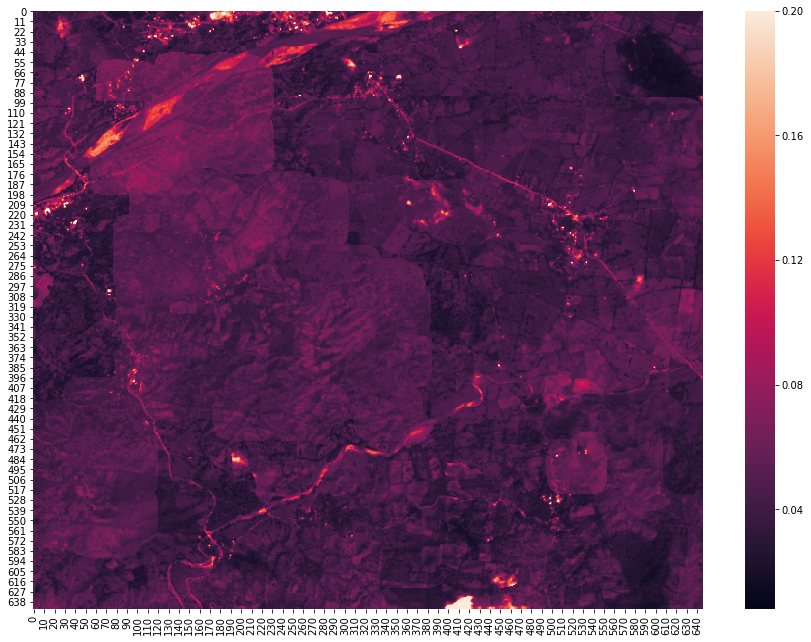

In [644]:
plt.figure(figsize=(15, 11))
sns.heatmap(post[2, :, :, 0], vmax = 0.2)

In [470]:
def adjust_interpolated_areas(array, interp):
    for time in range(array.shape[0]):
        for band in range(array.shape[-1]):
            interp_i = interp[time, :, :, band]
            array_i = array[time, :, :, band]
            if np.sum(interp_i) > 0:
                adj = (np.median(array_i[np.where(interp_i == 0)]) - 
                      (np.median(array_i[np.where(interp_i == 1)])))
                print(f"Adjusting {time} and {band} by {adj}")
                array_i[np.where(interp_i == 1)] += adj
                array[time, :, :, band] = array_i
    return array

0.009628442816815422


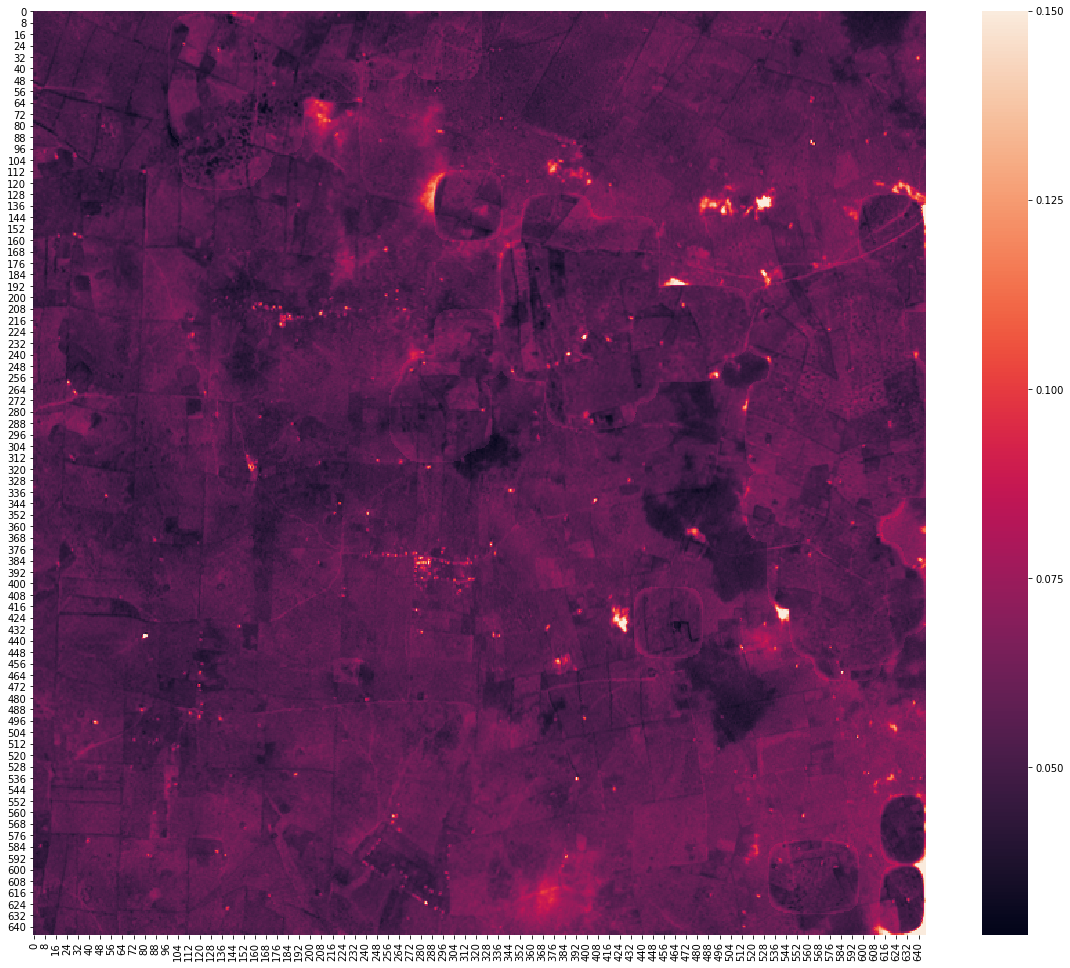

In [452]:
plt.figure(figsize=(20, 17))
interp_4 = interp[5, :, :, 0]
post_4 = post[5, :, :, 0]
adj = (np.median(post_4[np.where(interp_4 == 0)]) - 
           (np.median(post_4[np.where(interp_4 == 1)])))
print(adj)
post_4[np.where(interp_4 == 1)] += adj
sns.heatmap(post_4, vmax = 0.15)

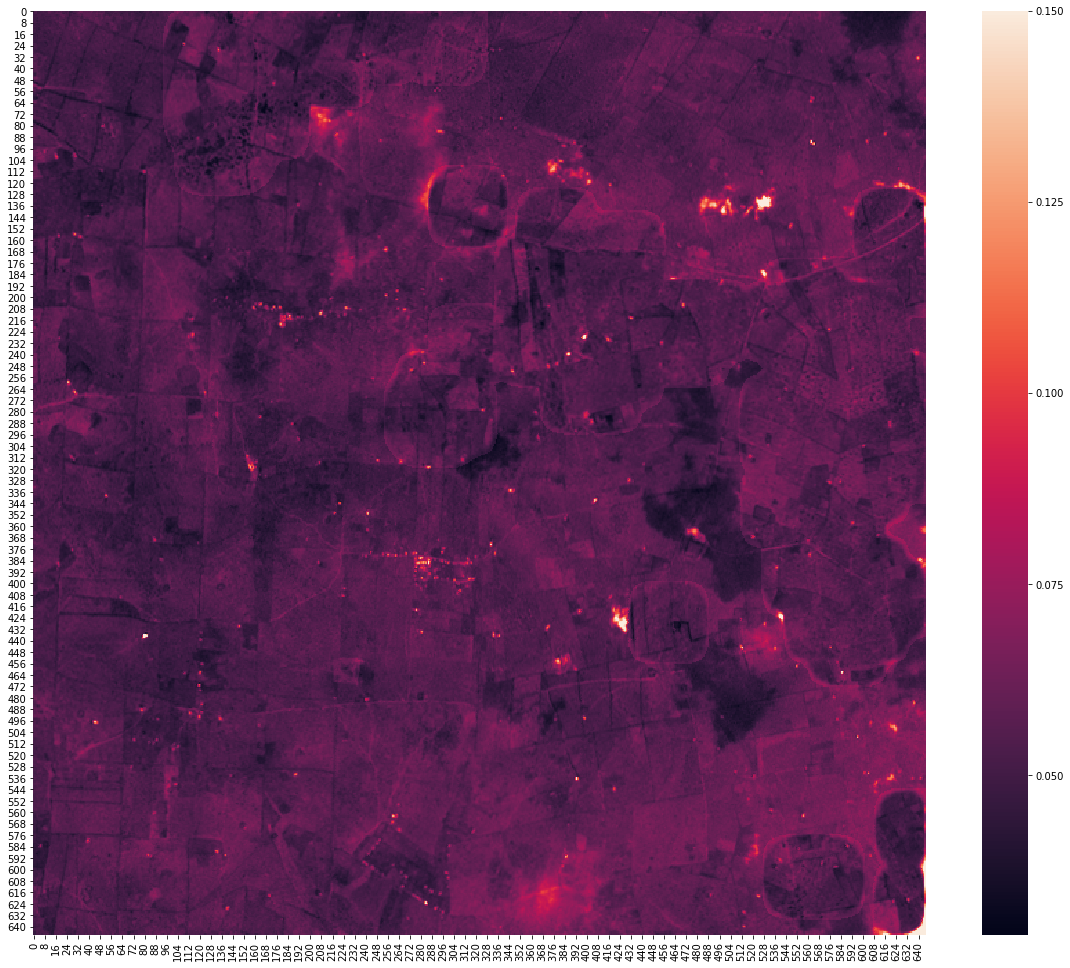

In [477]:
plt.figure(figsize=(20, 17))
sns.heatmap(post[5, :, :, 0], vmax = 0.15)

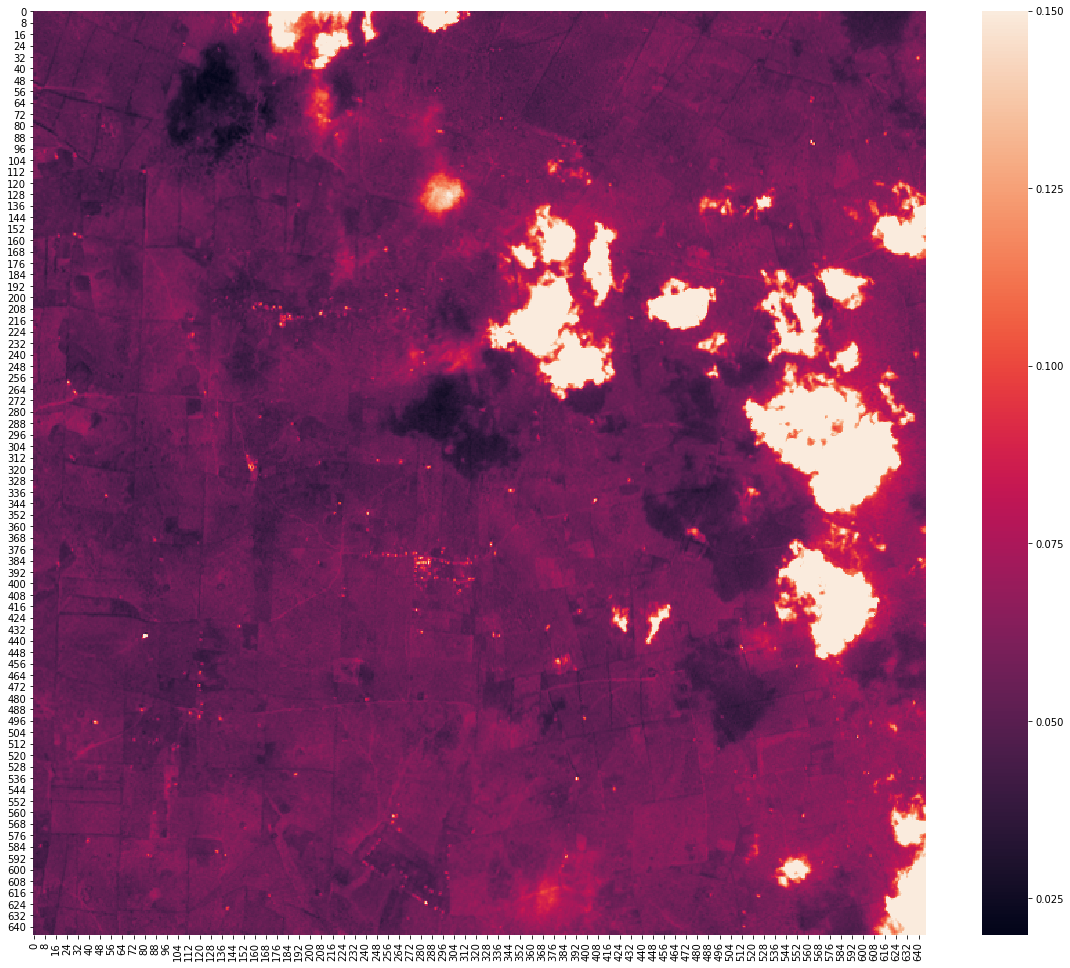

In [451]:
plt.figure(figsize=(20, 17))
sns.heatmap(x[5, :, :, 0], vmax = 0.15)

In [463]:
def reject_outliers(data_in, m = 2):
    data = np.copy(data_in)
    d = data - np.median(data, axis = (0))
    mdev = np.median(data, axis = 0)
    s = d / mdev
    n_changed = 0
    for x in tnrange(data.shape[1]):
        for y in range(data.shape[2]):
            for band in range(data.shape[3]):
                to_correct = np.where(s[:, x, y, band] > m) 
                data[to_correct, x, y, band] = mdev[x, y, band]
                n_changed += len(to_correct[0])
    print(f"Rejected {n_changed} outliers")
    return data

def remove_outliers(array):
    for x_window in range(0, array.shape[1], 10):
        for y_window in range(0, array.shape[2], 10):
            for band in range(0, array.shape[3], 1):
                local_min = x
                local_max = y
                
    return array

In [473]:
#post = adjust_interpolated_areas(post, interp)
data = reject_outliers(post)


Rejected 7145 outliers


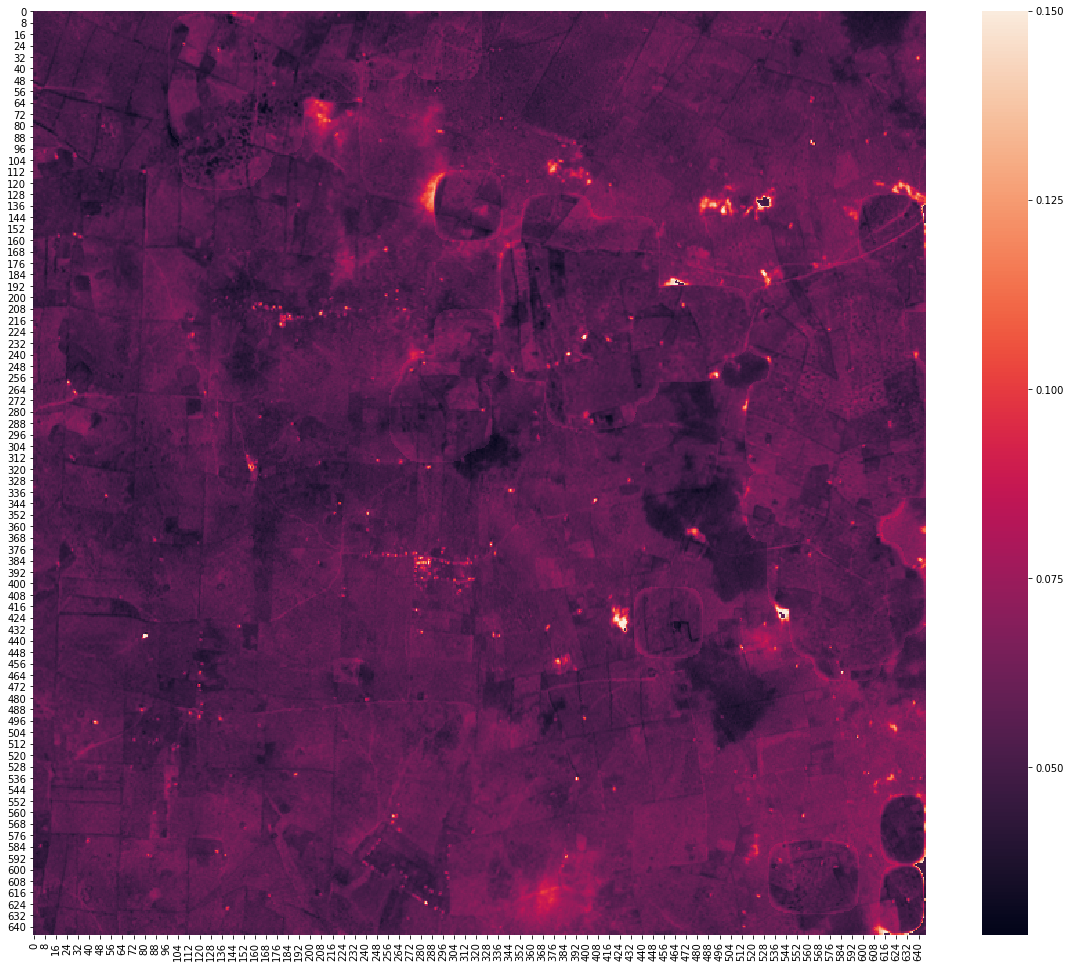

In [474]:
plt.figure(figsize=(20, 17))
sns.heatmap(data[5, :, :, 0], vmax = 0.15)

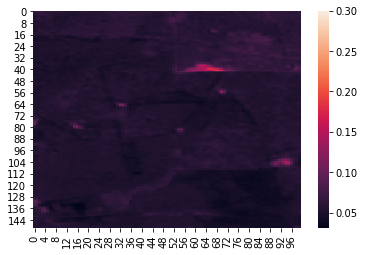

In [475]:
sns.heatmap(post[5, 150:300, 400:500, 0], vmax = 0.3)

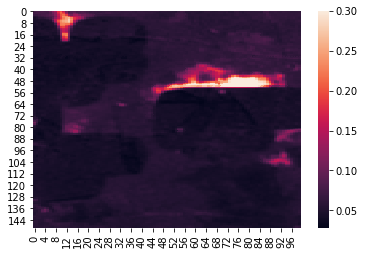

In [353]:
sns.heatmap(post[5, 150:300, 400:500, 0], vmax = 0.3)

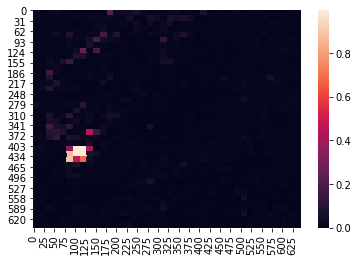

In [301]:
sns.heatmap(clouds[-3])

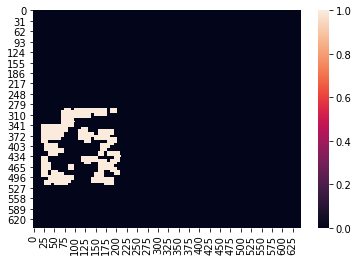

In [300]:
shadows = hkl.load("../../tile_data/guatemala-gain-2/2019/raw/clouds/shadows_0_0.hkl")
sns.heatmap(shadows[-3])

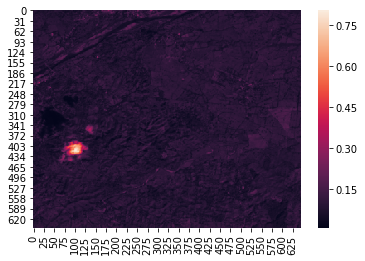

In [193]:
sns.heatmap(x[-3, :, :, 4])

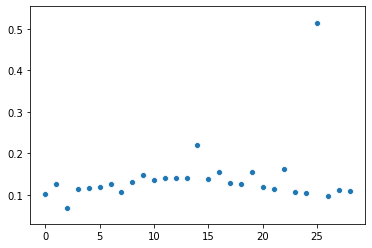

In [268]:
before_smooth = x[:, 35, 25, 4]
sns.scatterplot([x for x in range(x.shape[0])], before_smooth)
#plt.ylim(0.17, 0.4)

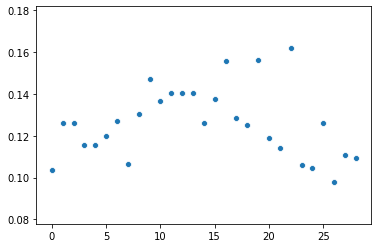

In [186]:
fixed = reject_outliers(before_smooth)
sns.scatterplot([x for x in range(x.shape[0])], fixed)
#plt.ylim(0.17, 0.4)

In [187]:
splu_coef = initialize_smoother(500, int(x.shape[0]))
smoothed = smooth(before_smooth)

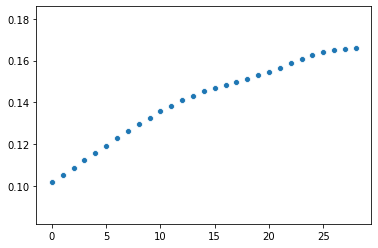

In [188]:
sns.scatterplot([x for x in range(x.shape[0])], smoothed)
#plt.ylim(0.17, 0.4)

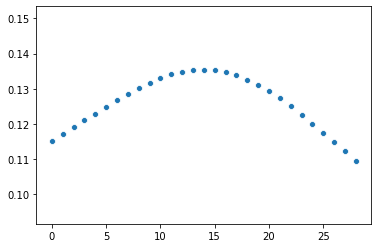

In [189]:
smoothed = smooth(fixed)
sns.scatterplot([x for x in range(x.shape[0])], smoothed)
#plt.ylim(0.17, 0.4)